In [1]:
# This notebook was built on Google colab and uses data form google drive
# Also the notebook was built using multiple sessions saving the intermediate outputs to avoid overshooting the RAM

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
import math
import pickle

### Load data

In [4]:
parent_folder = "/content/drive/MyDrive/AAIC/Projects/Facebook Friend Recommendation /data"
train_graph = nx.read_edgelist(parent_folder + '/train_pos.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)
print(nx.info(train_graph))

DiGraph with 1780722 nodes and 7550015 edges


In [5]:
df_final_train = pd.read_hdf(parent_folder + '/Features/sample_with_features_2.h5', 'train_df',mode='r')
df_final_test = pd.read_hdf(parent_folder + '/Features/sample_with_features_2.h5', 'test_df',mode='r')

In [6]:
df_final_train.shape

(100001, 13)

In [7]:
df_final_train.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_following_s,num_following_d,inter_followers,inter_following,does_follow_back,shortest_path,same_wcc_com,adar_index
0,273084,1505602,1,11,15,6,8,0,0,0,4,1,0.00000
1,1593259,673140,1,8,3,19,8,0,0,0,4,1,0.00000
2,355711,1610892,1,9,18,2,1,1,0,1,3,1,0.00000
3,80115,1473881,1,3,55,83,99,1,12,0,2,1,6.12441
4,336918,226190,1,14,16,7,5,0,0,1,4,1,0.00000


In [8]:
df_final_test.shape

(50001, 13)

In [9]:
df_final_test.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_following_s,num_following_d,inter_followers,inter_following,does_follow_back,shortest_path,same_wcc_com,adar_index
0,848424,784690,1,6,6,14,9,1,0,1,2,1,0.000000
1,1190268,217891,1,34,35,17,21,3,5,1,2,1,3.450508
2,1095925,325140,1,0,2,12,13,0,1,0,2,1,1.183295
3,571364,684722,1,1,6,7,2,0,0,0,2,1,0.000000
4,1851322,840484,1,5,7,7,13,2,5,1,2,1,12.434176


### Jaccard Index
\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

Reference : https://www.statisticshowto.com/jaccard-index/<br>
A = {0,1,2,5,6}<br>
B = {0,2,3,4,5,7,9}<br>
J(A,B) = |A∩B| / |A∪B| = |{0,2,5}| / |{0,1,2,3,4,5,6,7,9}| = 3/9 = 0.33

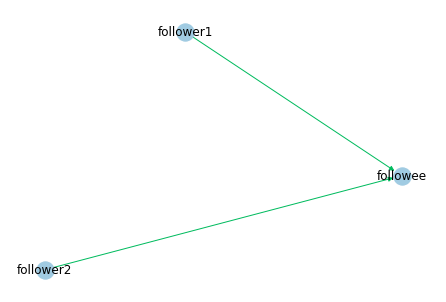

In [10]:
dg1 = nx.DiGraph()
dg1.add_edge("follower1", "followee")
dg1.add_edge("follower2", "followee")
pos1=nx.spring_layout(dg1)

nx.draw(dg1,pos1,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)

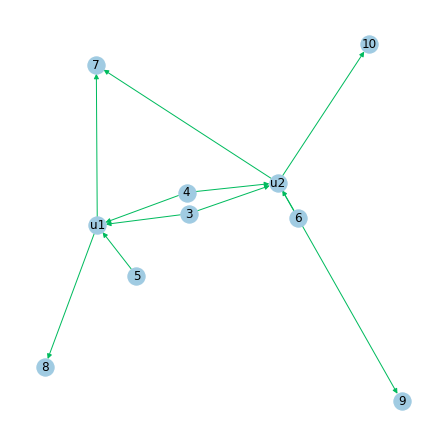

In [15]:
dg2 = nx.DiGraph()
dg2.add_edge(3, "u1")
dg2.add_edge(4, "u1")
dg2.add_edge(5, "u1")
dg2.add_edge("u1", 7)
dg2.add_edge("u1", 8)
dg2.add_edge(3, "u2")
dg2.add_edge(4, "u2")
dg2.add_edge(6, "u2")
dg2.add_edge("u2", 7)
dg2.add_edge("u2", 9)
dg2.add_edge("u2", 10)
pos2=nx.spring_layout(dg2)

plt.figure(figsize=(6,6))
nx.draw(dg2,pos2,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)

Here,<br>


```
X = followers of u1 = {3,4,5}
Y = followers of u2 = {3,4,6}
J(X, Y) =  |X∩Y| / |X∪Y|
        = 2/4
        = 0.5
```
Therefore, Jaccard index between u1 and u2 for followers is 0.5

```
X = users followed by u1 = {7,8}
Y = users followed by u2 = {7,9,10}
J(X, Y) =  |X∩Y| / |X∪Y|
        = 1/4
        = 0.25
```
Therefore, Jaccard index between u1 and u2 for be followee is 0.25





In [26]:
#for followees
def jaccard_for_following(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        intersection = len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        union = len(set(train_graph.successors(a)).union(set(train_graph.successors(b))))
        j = intersection/union
    except:
        return 0
    return j

#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        intersection = len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b))))
        union = len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b))))
        j = intersection/union

        return j
    except:
        return 0

In [27]:
jaccard_for_followers(1,181253)

0.25

In [28]:
jaccard_for_following(189226, 315892)

0.07407407407407407

In [29]:
# jaccard for followers on train
df_final_train['jaccard_followers'] = df_final_train.apply(lambda row : jaccard_for_followers(row['source_node'], row['destination_node']), axis=1)

# jaccard for followers on test
df_final_test['jaccard_followers'] = df_final_test.apply(lambda row : jaccard_for_followers(row['source_node'], row['destination_node']), axis=1)

# jaccard for following on train
df_final_train['jaccard_following'] = df_final_train.apply(lambda row : jaccard_for_following(row['source_node'], row['destination_node']), axis=1)

# jaccard for following on test
df_final_test['jaccard_following'] = df_final_test.apply(lambda row : jaccard_for_following(row['source_node'], row['destination_node']), axis=1)

### Cosine Distance (Otsuka-Ochiai coefficient)
\begin{equation}
CosineDistance = \frac{|X\cap Y|}{\sqrt{|X|\cdot|Y|} }
\end{equation}

In [41]:
#for followees
def cosine_for_following(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        numerator = len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        denominator = math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b)))))
        c = numerator/denominator
        return c
    except:
        return 0

#for followers
def cosine_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        numerator = len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b))))
        denominator = math.sqrt(len(set(train_graph.predecessors(a)))*len((set(train_graph.predecessors(b)))))
        c = numerator/denominator
        return c
    except:
        return 0

In [42]:
cosine_for_followers(1,181253)

0.4082482904638631

In [43]:
cosine_for_following(189226, 315892)

0.2

In [44]:
# cosine for followers on train
df_final_train['cosine_followers'] = df_final_train.apply(lambda row : cosine_for_followers(row['source_node'], row['destination_node']), axis=1)

# cosine for followers on test
df_final_test['cosine_followers'] = df_final_test.apply(lambda row : cosine_for_followers(row['source_node'], row['destination_node']), axis=1)

# cosine for following on train
df_final_train['cosine_following'] = df_final_train.apply(lambda row : cosine_for_following(row['source_node'], row['destination_node']), axis=1)

# cosine for following on test
df_final_test['cosine_following'] = df_final_test.apply(lambda row : cosine_for_following(row['source_node'], row['destination_node']), axis=1)

In [45]:
df_final_train.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_following_s,num_following_d,inter_followers,inter_following,does_follow_back,shortest_path,same_wcc_com,adar_index,jaccard_followers,jaccard_following,cosine_followers,cosine_following
0,273084,1505602,1,11,15,6,8,0,0,0,4,1,0.00000,0.000000,0.000000,0.000000,0.000000
1,1593259,673140,1,8,3,19,8,0,0,0,4,1,0.00000,0.000000,0.000000,0.000000,0.000000
2,355711,1610892,1,9,18,2,1,1,0,1,3,1,0.00000,0.100000,0.000000,0.235702,0.000000
3,80115,1473881,1,3,55,83,99,1,12,0,2,1,6.12441,0.011765,0.084507,0.063372,0.162623
4,336918,226190,1,14,16,7,5,0,0,1,4,1,0.00000,0.000000,0.000000,0.000000,0.000000


### Page Rank
- In a nutshell, given a directed graph, page rank will give each node a relative score based on how important the node is.<br>
- This depends on the number and quality of the in-degree links.
- i.e. Users with more followers will get bigger score

<br>

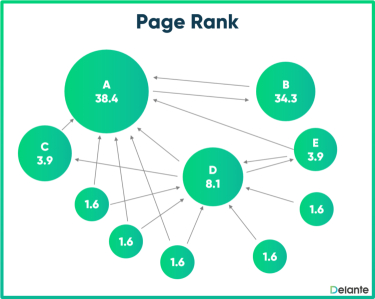
<br>
Reference : https://delante.co/definitions/pagerank/

In [46]:
pageranks = nx.pagerank(train_graph, alpha=0.85)

In [47]:
pickle.dump(pageranks, open(parent_folder + '/Features/pageranks.p', 'wb'))

In [48]:
mean_rank = float(sum(pageranks.values())) / len(pageranks)
mean_rank

5.615699699389075e-07

In [49]:
# for missing pagerank, imputing mean_rank

# pagerank for source in train
df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda node : pageranks.get(node, mean_rank))

# pagerank for destination in train
df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda node : pageranks.get(node, mean_rank))

# pagerank for source in test
df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda node : pageranks.get(node, mean_rank))

# pagerank for destination in test
df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda node : pageranks.get(node, mean_rank))

In [50]:
df_final_train.head(1)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_following_s,num_following_d,inter_followers,inter_following,does_follow_back,shortest_path,same_wcc_com,adar_index,jaccard_followers,jaccard_following,cosine_followers,cosine_following,page_rank_s,page_rank_d
0,273084,1505602,1,11,15,6,8,0,0,0,4,1,0.0,0.0,0.0,0.0,0.0,0.000002,3.459963e-07


### Katz Centrality
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/

In [51]:
katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)

In [52]:
pickle.dump(katz, open(parent_folder + '/Features/katz.p', 'wb'))

In [55]:
mean_katz = float(sum(katz.values())) / len(katz)

In [56]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',mean_katz)

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [57]:
# for missing katz, imputing mean_katz

# katz for source in train
df_final_train['katz_s'] = df_final_train.source_node.apply(lambda node : katz.get(node, mean_katz))

# katz for destination in train
df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda node : katz.get(node, mean_katz))

# katz for source in test
df_final_test['katz_s'] = df_final_test.source_node.apply(lambda node : katz.get(node, mean_katz))

# katz for destination in test
df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda node : katz.get(node, mean_katz))

In [59]:
df_final_train.head(5)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_following_s,num_following_d,inter_followers,inter_following,does_follow_back,...,same_wcc_com,adar_index,jaccard_followers,jaccard_following,cosine_followers,cosine_following,page_rank_s,page_rank_d,katz_s,katz_d
0,273084,1505602,1,11,15,6,8,0,0,0,...,1,0.00000,0.000000,0.000000,0.000000,0.000000,2.045290e-06,3.459963e-07,0.000773,0.000756
1,1593259,673140,1,8,3,19,8,0,0,0,...,1,0.00000,0.000000,0.000000,0.000000,0.000000,1.373377e-06,1.886069e-06,0.000762,0.000806
2,355711,1610892,1,9,18,2,1,1,0,1,...,1,0.00000,0.100000,0.000000,0.235702,0.000000,1.394824e-06,2.875504e-07,0.000766,0.000739
3,80115,1473881,1,3,55,83,99,1,12,0,...,1,6.12441,0.011765,0.084507,0.063372,0.162623,1.827472e-07,8.809712e-07,0.000745,0.001098
4,336918,226190,1,14,16,7,5,0,0,1,...,1,0.00000,0.000000,0.000000,0.000000,0.000000,1.198466e-06,5.000005e-07,0.000785,0.000758


### Features added

*   jaccard_followers : Jaccard index between source and destination for followers
*   jaccard_following : Jaccard index between source and destination for following
*   cosine_followers : Cosine distance between source and destination for followers
*   cosine_following : Cosine distance between source and destination for following
*   page_rank_s : Page rank for source node
*   page_rank_d : Page rank for destination node
*   katz_s : Katz centrality for source node
*   katz_d : Katz centrality for destination node


### Save results

In [60]:
hdf = pd.HDFStore(parent_folder + '/Features/sample_with_features_3.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()